In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [4096,2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_4096_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 834)
(878801, 3)
validation
(151459, 834)
(151459, 3)
test
(112754, 834)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 834)]             0         


 dense (Dense)               (None, 4096)              3420160   


 dense_1 (Dense)             (None, 2048)              8390656   


 dense_2 (Dense)             (None, 1024)              2098176   


 dense_3 (Dense)             (None, 512)               524800    


 dense_4 (Dense)             (None, 256)               131328    


 dense_5 (Dense)             (None, 128)               32896     


 dense_6 (Dense)             (None, 3)                 387       


Total params: 14598403 (55.69 MB)


Trainable params: 14598403 (55.69 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 3:21 - loss: 1.1772 - STD: 0.1779 - MAE: 0.4190

2/9 [=====>........................] - ETA: 7s - loss: 1.1274 - STD: 0.1130 - MAE: 0.4283  

3/9 [=========>....................] - ETA: 6s - loss: 1.1264 - STD: 0.0903 - MAE: 0.4350

4/9 [============>.................] - ETA: 5s - loss: 1.1201 - STD: 0.0728 - MAE: 0.4374

5/9 [===============>..............] - ETA: 22s - loss: 1.1128 - STD: 0.0684 - MAE: 0.4373

6/9 [===================>..........] - ETA: 13s - loss: 1.1066 - STD: 0.0730 - MAE: 0.4361

7/9 [======================>.......] - ETA: 8s - loss: 1.1042 - STD: 0.0797 - MAE: 0.4349 

8/9 [=========================>....] - ETA: 3s - loss: 1.1028 - STD: 0.0853 - MAE: 0.4338

9/9 [==============================] - ETA: 0s - loss: 1.1011 - STD: 0.0890 - MAE: 0.4331

9/9 [==============================] - 58s 4s/step - loss: 1.1011 - STD: 0.0890 - MAE: 0.4331 - val_loss: 1.0798 - val_STD: 0.1036 - val_MAE: 0.4294


Epoch 2/10000


1/9 [==>...........................] - ETA: 11s - loss: 1.0813 - STD: 0.1036 - MAE: 0.4296

2/9 [=====>........................] - ETA: 7s - loss: 1.0780 - STD: 0.0943 - MAE: 0.4309 

3/9 [=========>....................] - ETA: 6s - loss: 1.0772 - STD: 0.0841 - MAE: 0.4324

4/9 [============>.................] - ETA: 4s - loss: 1.0775 - STD: 0.0739 - MAE: 0.4339

5/9 [===============>..............] - ETA: 3s - loss: 1.0786 - STD: 0.0658 - MAE: 0.4351

6/9 [===================>..........] - ETA: 2s - loss: 1.0793 - STD: 0.0604 - MAE: 0.4358

7/9 [======================>.......] - ETA: 1s - loss: 1.0791 - STD: 0.0579 - MAE: 0.4362

8/9 [=========================>....] - ETA: 0s - loss: 1.0787 - STD: 0.0580 - MAE: 0.4362

9/9 [==============================] - ETA: 0s - loss: 1.0781 - STD: 0.0598 - MAE: 0.4359

9/9 [==============================] - 11s 1s/step - loss: 1.0781 - STD: 0.0598 - MAE: 0.4359 - val_loss: 1.0747 - val_STD: 0.0858 - val_MAE: 0.4320


Epoch 3/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0754 - STD: 0.0858 - MAE: 0.4321

2/9 [=====>........................] - ETA: 7s - loss: 1.0761 - STD: 0.0893 - MAE: 0.4316

3/9 [=========>....................] - ETA: 6s - loss: 1.0767 - STD: 0.0916 - MAE: 0.4312

4/9 [============>.................] - ETA: 5s - loss: 1.0772 - STD: 0.0927 - MAE: 0.4311

5/9 [===============>..............] - ETA: 4s - loss: 1.0768 - STD: 0.0926 - MAE: 0.4310

6/9 [===================>..........] - ETA: 3s - loss: 1.0767 - STD: 0.0916 - MAE: 0.4312

7/9 [======================>.......] - ETA: 2s - loss: 1.0762 - STD: 0.0894 - MAE: 0.4315

8/9 [=========================>....] - ETA: 1s - loss: 1.0760 - STD: 0.0863 - MAE: 0.4320

9/9 [==============================] - ETA: 0s - loss: 1.0759 - STD: 0.0831 - MAE: 0.4325

9/9 [==============================] - 10s 1s/step - loss: 1.0759 - STD: 0.0831 - MAE: 0.4325 - val_loss: 1.0758 - val_STD: 0.0532 - val_MAE: 0.4367


Epoch 4/10000


1/9 [==>...........................] - ETA: 11s - loss: 1.0763 - STD: 0.0532 - MAE: 0.4368

2/9 [=====>........................] - ETA: 7s - loss: 1.0763 - STD: 0.0543 - MAE: 0.4367 

3/9 [=========>....................] - ETA: 6s - loss: 1.0757 - STD: 0.0563 - MAE: 0.4363

4/9 [============>.................] - ETA: 5s - loss: 1.0752 - STD: 0.0587 - MAE: 0.4359

5/9 [===============>..............] - ETA: 4s - loss: 1.0749 - STD: 0.0613 - MAE: 0.4356

6/9 [===================>..........] - ETA: 3s - loss: 1.0749 - STD: 0.0639 - MAE: 0.4352

7/9 [======================>.......] - ETA: 1s - loss: 1.0749 - STD: 0.0663 - MAE: 0.4349

8/9 [=========================>....] - ETA: 0s - loss: 1.0750 - STD: 0.0685 - MAE: 0.4346

9/9 [==============================] - ETA: 0s - loss: 1.0750 - STD: 0.0703 - MAE: 0.4343

9/9 [==============================] - 11s 1s/step - loss: 1.0750 - STD: 0.0703 - MAE: 0.4343 - val_loss: 1.0743 - val_STD: 0.0827 - val_MAE: 0.4324


Epoch 5/10000


1/9 [==>...........................] - ETA: 11s - loss: 1.0756 - STD: 0.0827 - MAE: 0.4327

2/9 [=====>........................] - ETA: 7s - loss: 1.0750 - STD: 0.0806 - MAE: 0.4329 

3/9 [=========>....................] - ETA: 6s - loss: 1.0745 - STD: 0.0780 - MAE: 0.4332

4/9 [============>.................] - ETA: 5s - loss: 1.0744 - STD: 0.0754 - MAE: 0.4336

5/9 [===============>..............] - ETA: 4s - loss: 1.0744 - STD: 0.0731 - MAE: 0.4339

6/9 [===================>..........] - ETA: 2s - loss: 1.0744 - STD: 0.0716 - MAE: 0.4341

7/9 [======================>.......] - ETA: 2s - loss: 1.0744 - STD: 0.0706 - MAE: 0.4342

8/9 [=========================>....] - ETA: 1s - loss: 1.0743 - STD: 0.0702 - MAE: 0.4343

9/9 [==============================] - ETA: 0s - loss: 1.0743 - STD: 0.0702 - MAE: 0.4343

9/9 [==============================] - 11s 1s/step - loss: 1.0743 - STD: 0.0702 - MAE: 0.4343 - val_loss: 1.0736 - val_STD: 0.0727 - val_MAE: 0.4339


Epoch 6/10000


1/9 [==>...........................] - ETA: 12s - loss: 1.0730 - STD: 0.0727 - MAE: 0.4337

2/9 [=====>........................] - ETA: 7s - loss: 1.0739 - STD: 0.0742 - MAE: 0.4336 

3/9 [=========>....................] - ETA: 6s - loss: 1.0740 - STD: 0.0755 - MAE: 0.4335

4/9 [============>.................] - ETA: 4s - loss: 1.0740 - STD: 0.0765 - MAE: 0.4333

5/9 [===============>..............] - ETA: 3s - loss: 1.0740 - STD: 0.0770 - MAE: 0.4332

6/9 [===================>..........] - ETA: 2s - loss: 1.0740 - STD: 0.0768 - MAE: 0.4333

7/9 [======================>.......] - ETA: 2s - loss: 1.0741 - STD: 0.0763 - MAE: 0.4334

8/9 [=========================>....] - ETA: 1s - loss: 1.0740 - STD: 0.0755 - MAE: 0.4335

9/9 [==============================] - ETA: 0s - loss: 1.0739 - STD: 0.0747 - MAE: 0.4336

9/9 [==============================] - 11s 1s/step - loss: 1.0739 - STD: 0.0747 - MAE: 0.4336 - val_loss: 1.0733 - val_STD: 0.0672 - val_MAE: 0.4345


Epoch 7/10000


1/9 [==>...........................] - ETA: 11s - loss: 1.0732 - STD: 0.0672 - MAE: 0.4345

2/9 [=====>........................] - ETA: 7s - loss: 1.0729 - STD: 0.0673 - MAE: 0.4344 

3/9 [=========>....................] - ETA: 5s - loss: 1.0731 - STD: 0.0680 - MAE: 0.4344

4/9 [============>.................] - ETA: 4s - loss: 1.0730 - STD: 0.0691 - MAE: 0.4342

5/9 [===============>..............] - ETA: 3s - loss: 1.0729 - STD: 0.0702 - MAE: 0.4340

6/9 [===================>..........] - ETA: 2s - loss: 1.0728 - STD: 0.0709 - MAE: 0.4338

7/9 [======================>.......] - ETA: 2s - loss: 1.0723 - STD: 0.0716 - MAE: 0.4336

8/9 [=========================>....] - ETA: 1s - loss: 1.0719 - STD: 0.0722 - MAE: 0.4334

9/9 [==============================] - ETA: 0s - loss: 1.0713 - STD: 0.0723 - MAE: 0.4333

9/9 [==============================] - 11s 1s/step - loss: 1.0713 - STD: 0.0723 - MAE: 0.4333 - val_loss: 1.0641 - val_STD: 0.0776 - val_MAE: 0.4307


Epoch 8/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0651 - STD: 0.0780 - MAE: 0.4308

2/9 [=====>........................] - ETA: 7s - loss: 1.0644 - STD: 0.0728 - MAE: 0.4314

3/9 [=========>....................] - ETA: 6s - loss: 1.0626 - STD: 0.0765 - MAE: 0.4304

4/9 [============>.................] - ETA: 5s - loss: 1.0585 - STD: 0.0744 - MAE: 0.4298

5/9 [===============>..............] - ETA: 4s - loss: 1.0544 - STD: 0.0750 - MAE: 0.4286

6/9 [===================>..........] - ETA: 3s - loss: 1.0496 - STD: 0.0752 - MAE: 0.4274

7/9 [======================>.......] - ETA: 2s - loss: 1.0496 - STD: 0.0828 - MAE: 0.4259

8/9 [=========================>....] - ETA: 1s - loss: 1.0491 - STD: 0.0866 - MAE: 0.4252

9/9 [==============================] - ETA: 0s - loss: 1.0461 - STD: 0.0913 - MAE: 0.4234

9/9 [==============================] - 11s 1s/step - loss: 1.0461 - STD: 0.0913 - MAE: 0.4234 - val_loss: 1.0045 - val_STD: 0.1232 - val_MAE: 0.4065


Epoch 9/10000


1/9 [==>...........................] - ETA: 11s - loss: 1.0060 - STD: 0.1237 - MAE: 0.4068

2/9 [=====>........................] - ETA: 7s - loss: 1.0078 - STD: 0.1248 - MAE: 0.4076 

3/9 [=========>....................] - ETA: 6s - loss: 0.9953 - STD: 0.1231 - MAE: 0.4048

4/9 [============>.................] - ETA: 5s - loss: 0.9917 - STD: 0.1275 - MAE: 0.4027

5/9 [===============>..............] - ETA: 4s - loss: 0.9841 - STD: 0.1293 - MAE: 0.4005

6/9 [===================>..........] - ETA: 3s - loss: 0.9779 - STD: 0.1330 - MAE: 0.3981

7/9 [======================>.......] - ETA: 2s - loss: 0.9774 - STD: 0.1413 - MAE: 0.3952

8/9 [=========================>....] - ETA: 1s - loss: 0.9727 - STD: 0.1456 - MAE: 0.3927

9/9 [==============================] - ETA: 0s - loss: 0.9711 - STD: 0.1501 - MAE: 0.3911

9/9 [==============================] - 11s 1s/step - loss: 0.9711 - STD: 0.1501 - MAE: 0.3911 - val_loss: 1.0374 - val_STD: 0.2355 - val_MAE: 0.3734


Epoch 10/10000


1/9 [==>...........................] - ETA: 8s - loss: 1.0419 - STD: 0.2349 - MAE: 0.3746

2/9 [=====>........................] - ETA: 7s - loss: 1.0250 - STD: 0.2236 - MAE: 0.3766

3/9 [=========>....................] - ETA: 6s - loss: 0.9914 - STD: 0.2034 - MAE: 0.3777

4/9 [============>.................] - ETA: 5s - loss: 1.0098 - STD: 0.2023 - MAE: 0.3824

5/9 [===============>..............] - ETA: 4s - loss: 0.9990 - STD: 0.1904 - MAE: 0.3843

6/9 [===================>..........] - ETA: 3s - loss: 1.0059 - STD: 0.1813 - MAE: 0.3889

7/9 [======================>.......] - ETA: 2s - loss: 1.0131 - STD: 0.1731 - MAE: 0.3932

8/9 [=========================>....] - ETA: 1s - loss: 1.0142 - STD: 0.1642 - MAE: 0.3961

9/9 [==============================] - ETA: 0s - loss: 1.0122 - STD: 0.1590 - MAE: 0.3973

9/9 [==============================] - 11s 1s/step - loss: 1.0122 - STD: 0.1590 - MAE: 0.3973 - val_loss: 0.9909 - val_STD: 0.1558 - val_MAE: 0.3971


Epoch 11/10000


1/9 [==>...........................] - ETA: 11s - loss: 0.9969 - STD: 0.1529 - MAE: 0.3996

2/9 [=====>........................] - ETA: 7s - loss: 0.9934 - STD: 0.1641 - MAE: 0.3954 

3/9 [=========>....................] - ETA: 6s - loss: 0.9818 - STD: 0.1695 - MAE: 0.3906

4/9 [============>.................] - ETA: 5s - loss: 0.9688 - STD: 0.1754 - MAE: 0.3852

5/9 [===============>..............] - ETA: 4s - loss: 0.9627 - STD: 0.1839 - MAE: 0.3802

6/9 [===================>..........] - ETA: 2s - loss: 0.9572 - STD: 0.1903 - MAE: 0.3759

7/9 [======================>.......] - ETA: 1s - loss: 0.9570 - STD: 0.1935 - MAE: 0.3744

8/9 [=========================>....] - ETA: 1s - loss: 0.9533 - STD: 0.1970 - MAE: 0.3719

9/9 [==============================] - ETA: 0s - loss: 0.9523 - STD: 0.2001 - MAE: 0.3701

9/9 [==============================] - 11s 1s/step - loss: 0.9523 - STD: 0.2001 - MAE: 0.3701 - val_loss: 0.9755 - val_STD: 0.1964 - val_MAE: 0.3740


Epoch 12/10000


1/9 [==>...........................] - ETA: 11s - loss: 0.9313 - STD: 0.1969 - MAE: 0.3656

2/9 [=====>........................] - ETA: 7s - loss: 0.9293 - STD: 0.1954 - MAE: 0.3659 

3/9 [=========>....................] - ETA: 5s - loss: 0.9279 - STD: 0.2021 - MAE: 0.3627

4/9 [============>.................] - ETA: 4s - loss: 0.9234 - STD: 0.2024 - MAE: 0.3619

5/9 [===============>..............] - ETA: 3s - loss: 0.9221 - STD: 0.1987 - MAE: 0.3633

6/9 [===================>..........] - ETA: 2s - loss: 0.9189 - STD: 0.1977 - MAE: 0.3632

7/9 [======================>.......] - ETA: 2s - loss: 0.9180 - STD: 0.1988 - MAE: 0.3626

8/9 [=========================>....] - ETA: 1s - loss: 0.9164 - STD: 0.1978 - MAE: 0.3626

9/9 [==============================] - ETA: 0s - loss: 0.9160 - STD: 0.1960 - MAE: 0.3634

9/9 [==============================] - 11s 1s/step - loss: 0.9160 - STD: 0.1960 - MAE: 0.3634 - val_loss: 0.9178 - val_STD: 0.1909 - val_MAE: 0.3660


Epoch 13/10000


1/9 [==>...........................] - ETA: 12s - loss: 0.9019 - STD: 0.1888 - MAE: 0.3631

2/9 [=====>........................] - ETA: 7s - loss: 0.9038 - STD: 0.1931 - MAE: 0.3618 

3/9 [=========>....................] - ETA: 6s - loss: 0.9018 - STD: 0.1907 - MAE: 0.3624

4/9 [============>.................] - ETA: 4s - loss: 0.9009 - STD: 0.1883 - MAE: 0.3633

5/9 [===============>..............] - ETA: 3s - loss: 0.8991 - STD: 0.1893 - MAE: 0.3626

6/9 [===================>..........] - ETA: 3s - loss: 0.8980 - STD: 0.1916 - MAE: 0.3615

7/9 [======================>.......] - ETA: 2s - loss: 0.8964 - STD: 0.1919 - MAE: 0.3611

8/9 [=========================>....] - ETA: 1s - loss: 0.8952 - STD: 0.1927 - MAE: 0.3605

9/9 [==============================] - ETA: 0s - loss: 0.8943 - STD: 0.1953 - MAE: 0.3593

9/9 [==============================] - 11s 1s/step - loss: 0.8943 - STD: 0.1953 - MAE: 0.3593 - val_loss: 0.9072 - val_STD: 0.2170 - val_MAE: 0.3518


Epoch 14/10000


1/9 [==>...........................] - ETA: 12s - loss: 0.8863 - STD: 0.2120 - MAE: 0.3506

2/9 [=====>........................] - ETA: 5s - loss: 0.8852 - STD: 0.2099 - MAE: 0.3513 

3/9 [=========>....................] - ETA: 5s - loss: 0.8840 - STD: 0.2136 - MAE: 0.3495

4/9 [============>.................] - ETA: 4s - loss: 0.8828 - STD: 0.2136 - MAE: 0.3493

5/9 [===============>..............] - ETA: 3s - loss: 0.8817 - STD: 0.2118 - MAE: 0.3498

6/9 [===================>..........] - ETA: 2s - loss: 0.8803 - STD: 0.2125 - MAE: 0.3493

7/9 [======================>.......] - ETA: 2s - loss: 0.8787 - STD: 0.2118 - MAE: 0.3493

8/9 [=========================>....] - ETA: 1s - loss: 0.8778 - STD: 0.2100 - MAE: 0.3499

9/9 [==============================] - ETA: 0s - loss: 0.8769 - STD: 0.2103 - MAE: 0.3496

9/9 [==============================] - 11s 1s/step - loss: 0.8769 - STD: 0.2103 - MAE: 0.3496 - val_loss: 0.8823 - val_STD: 0.2154 - val_MAE: 0.3484


Epoch 15/10000


1/9 [==>...........................] - ETA: 11s - loss: 0.8658 - STD: 0.2091 - MAE: 0.3481

2/9 [=====>........................] - ETA: 5s - loss: 0.8669 - STD: 0.2060 - MAE: 0.3497 

3/9 [=========>....................] - ETA: 5s - loss: 0.8681 - STD: 0.2122 - MAE: 0.3473

4/9 [============>.................] - ETA: 4s - loss: 0.8658 - STD: 0.2122 - MAE: 0.3468

5/9 [===============>..............] - ETA: 3s - loss: 0.8645 - STD: 0.2129 - MAE: 0.3463

6/9 [===================>..........] - ETA: 3s - loss: 0.8642 - STD: 0.2157 - MAE: 0.3450

7/9 [======================>.......] - ETA: 2s - loss: 0.8637 - STD: 0.2150 - MAE: 0.3452

8/9 [=========================>....] - ETA: 1s - loss: 0.8638 - STD: 0.2182 - MAE: 0.3437

9/9 [==============================] - ETA: 0s - loss: 0.8637 - STD: 0.2174 - MAE: 0.3440

9/9 [==============================] - 11s 1s/step - loss: 0.8637 - STD: 0.2174 - MAE: 0.3440 - val_loss: 0.8731 - val_STD: 0.2450 - val_MAE: 0.3325


Epoch 16/10000


1/9 [==>...........................] - ETA: 11s - loss: 0.8656 - STD: 0.2432 - MAE: 0.3328

2/9 [=====>........................] - ETA: 7s - loss: 0.8614 - STD: 0.2281 - MAE: 0.3387 

3/9 [=========>....................] - ETA: 6s - loss: 0.8565 - STD: 0.2290 - MAE: 0.3373

4/9 [============>.................] - ETA: 5s - loss: 0.8535 - STD: 0.2292 - MAE: 0.3366

5/9 [===============>..............] - ETA: 3s - loss: 0.8527 - STD: 0.2277 - MAE: 0.3371

6/9 [===================>..........] - ETA: 2s - loss: 0.8522 - STD: 0.2307 - MAE: 0.3357

7/9 [======================>.......] - ETA: 2s - loss: 0.8525 - STD: 0.2289 - MAE: 0.3365

8/9 [=========================>....] - ETA: 1s - loss: 0.8522 - STD: 0.2309 - MAE: 0.3356

9/9 [==============================] - ETA: 0s - loss: 0.8512 - STD: 0.2292 - MAE: 0.3362

9/9 [==============================] - 11s 1s/step - loss: 0.8512 - STD: 0.2292 - MAE: 0.3362 - val_loss: 0.8534 - val_STD: 0.2370 - val_MAE: 0.3327


Epoch 17/10000


1/9 [==>...........................] - ETA: 9s - loss: 0.8406 - STD: 0.2335 - MAE: 0.3324

2/9 [=====>........................] - ETA: 7s - loss: 0.8381 - STD: 0.2291 - MAE: 0.3338

3/9 [=========>....................] - ETA: 6s - loss: 0.8366 - STD: 0.2319 - MAE: 0.3322

4/9 [============>.................] - ETA: 5s - loss: 0.8365 - STD: 0.2334 - MAE: 0.3314

5/9 [===============>..............] - ETA: 4s - loss: 0.8357 - STD: 0.2343 - MAE: 0.3309

6/9 [===================>..........] - ETA: 3s - loss: 0.8357 - STD: 0.2358 - MAE: 0.3301

7/9 [======================>.......] - ETA: 2s - loss: 0.8358 - STD: 0.2346 - MAE: 0.3307

8/9 [=========================>....] - ETA: 1s - loss: 0.8400 - STD: 0.2389 - MAE: 0.3295

9/9 [==============================] - ETA: 0s - loss: 0.8522 - STD: 0.2351 - MAE: 0.3337

9/9 [==============================] - 11s 1s/step - loss: 0.8522 - STD: 0.2351 - MAE: 0.3337 - val_loss: 0.8748 - val_STD: 0.2695 - val_MAE: 0.3219


Epoch 18/10000


1/9 [==>...........................] - ETA: 11s - loss: 0.8918 - STD: 0.2700 - MAE: 0.3257

2/9 [=====>........................] - ETA: 7s - loss: 0.8634 - STD: 0.2414 - MAE: 0.3330 

3/9 [=========>....................] - ETA: 6s - loss: 0.8636 - STD: 0.2274 - MAE: 0.3395

4/9 [============>.................] - ETA: 5s - loss: 0.8607 - STD: 0.2344 - MAE: 0.3357

5/9 [===============>..............] - ETA: 4s - loss: 0.8554 - STD: 0.2364 - MAE: 0.3337

6/9 [===================>..........] - ETA: 3s - loss: 0.8547 - STD: 0.2352 - MAE: 0.3342

7/9 [======================>.......] - ETA: 2s - loss: 0.8524 - STD: 0.2385 - MAE: 0.3322

8/9 [=========================>....] - ETA: 1s - loss: 0.8503 - STD: 0.2388 - MAE: 0.3315

9/9 [==============================] - ETA: 0s - loss: 0.8498 - STD: 0.2359 - MAE: 0.3328

9/9 [==============================] - 11s 1s/step - loss: 0.8498 - STD: 0.2359 - MAE: 0.3328 - val_loss: 0.8410 - val_STD: 0.2351 - val_MAE: 0.3312


Epoch 19/10000


1/9 [==>...........................] - ETA: 11s - loss: 0.8305 - STD: 0.2331 - MAE: 0.3305

2/9 [=====>........................] - ETA: 7s - loss: 0.8342 - STD: 0.2414 - MAE: 0.3274 

3/9 [=========>....................] - ETA: 6s - loss: 0.8342 - STD: 0.2359 - MAE: 0.3298

4/9 [============>.................] - ETA: 4s - loss: 0.8330 - STD: 0.2373 - MAE: 0.3289

5/9 [===============>..............] - ETA: 3s - loss: 0.8343 - STD: 0.2428 - MAE: 0.3265

6/9 [===================>..........] - ETA: 3s - loss: 0.8362 - STD: 0.2408 - MAE: 0.3277

7/9 [======================>.......] - ETA: 2s - loss: 0.8348 - STD: 0.2425 - MAE: 0.3267

8/9 [=========================>....] - ETA: 1s - loss: 0.8331 - STD: 0.2426 - MAE: 0.3263

9/9 [==============================] - ETA: 0s - loss: 0.8331 - STD: 0.2403 - MAE: 0.3274

9/9 [==============================] - 11s 1s/step - loss: 0.8331 - STD: 0.2403 - MAE: 0.3274 - val_loss: 0.8373 - val_STD: 0.2478 - val_MAE: 0.3243


Epoch 20/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8250 - STD: 0.2474 - MAE: 0.3225

2/9 [=====>........................] - ETA: 5s - loss: 0.8220 - STD: 0.2423 - MAE: 0.3241 

3/9 [=========>....................] - ETA: 5s - loss: 0.8225 - STD: 0.2399 - MAE: 0.3254

4/9 [============>.................] - ETA: 4s - loss: 0.8249 - STD: 0.2451 - MAE: 0.3234

5/9 [===============>..............] - ETA: 3s - loss: 0.8270 - STD: 0.2421 - MAE: 0.3252

6/9 [===================>..........] - ETA: 2s - loss: 0.8271 - STD: 0.2443 - MAE: 0.3242

7/9 [======================>.......] - ETA: 1s - loss: 0.8263 - STD: 0.2430 - MAE: 0.3247

8/9 [=========================>....] - ETA: 1s - loss: 0.8258 - STD: 0.2419 - MAE: 0.3252

9/9 [==============================] - ETA: 0s - loss: 0.8259 - STD: 0.2431 - MAE: 0.3246

9/9 [==============================] - 10s 1s/step - loss: 0.8259 - STD: 0.2431 - MAE: 0.3246 - val_loss: 0.8652 - val_STD: 0.2372 - val_MAE: 0.3350


Epoch 21/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.8243 - STD: 0.2308 - MAE: 0.3303

2/9 [=====>........................] - ETA: 7s - loss: 0.8214 - STD: 0.2435 - MAE: 0.3236

3/9 [=========>....................] - ETA: 6s - loss: 0.8206 - STD: 0.2447 - MAE: 0.3228

4/9 [============>.................] - ETA: 5s - loss: 0.8191 - STD: 0.2454 - MAE: 0.3222

5/9 [===============>..............] - ETA: 4s - loss: 0.8199 - STD: 0.2475 - MAE: 0.3213

6/9 [===================>..........] - ETA: 3s - loss: 0.8207 - STD: 0.2451 - MAE: 0.3226

7/9 [======================>.......] - ETA: 2s - loss: 0.8209 - STD: 0.2468 - MAE: 0.3219

8/9 [=========================>....] - ETA: 1s - loss: 0.8205 - STD: 0.2453 - MAE: 0.3225

9/9 [==============================] - ETA: 0s - loss: 0.8201 - STD: 0.2457 - MAE: 0.3223

9/9 [==============================] - 10s 1s/step - loss: 0.8201 - STD: 0.2457 - MAE: 0.3223 - val_loss: 0.8449 - val_STD: 0.2506 - val_MAE: 0.3243


Epoch 22/10000


1/9 [==>...........................] - ETA: 12s - loss: 0.8148 - STD: 0.2469 - MAE: 0.3205

2/9 [=====>........................] - ETA: 7s - loss: 0.8141 - STD: 0.2496 - MAE: 0.3191 

3/9 [=========>....................] - ETA: 6s - loss: 0.8136 - STD: 0.2501 - MAE: 0.3187

4/9 [============>.................] - ETA: 4s - loss: 0.8141 - STD: 0.2505 - MAE: 0.3187

5/9 [===============>..............] - ETA: 3s - loss: 0.8143 - STD: 0.2492 - MAE: 0.3194

6/9 [===================>..........] - ETA: 3s - loss: 0.8141 - STD: 0.2494 - MAE: 0.3193

7/9 [======================>.......] - ETA: 2s - loss: 0.8145 - STD: 0.2477 - MAE: 0.3202

8/9 [=========================>....] - ETA: 1s - loss: 0.8161 - STD: 0.2504 - MAE: 0.3191

9/9 [==============================] - ETA: 0s - loss: 0.8217 - STD: 0.2475 - MAE: 0.3217

9/9 [==============================] - 11s 1s/step - loss: 0.8217 - STD: 0.2475 - MAE: 0.3217 - val_loss: 0.8652 - val_STD: 0.2887 - val_MAE: 0.3076


Epoch 23/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8904 - STD: 0.2942 - MAE: 0.3104

2/9 [=====>........................] - ETA: 7s - loss: 0.9023 - STD: 0.2493 - MAE: 0.3362 

3/9 [=========>....................] - ETA: 6s - loss: 0.8808 - STD: 0.2342 - MAE: 0.3391

4/9 [============>.................] - ETA: 5s - loss: 0.9014 - STD: 0.2513 - MAE: 0.3342

5/9 [===============>..............] - ETA: 4s - loss: 0.8942 - STD: 0.2413 - MAE: 0.3378

6/9 [===================>..........] - ETA: 3s - loss: 0.8970 - STD: 0.2346 - MAE: 0.3419

7/9 [======================>.......] - ETA: 1s - loss: 0.8897 - STD: 0.2323 - MAE: 0.3413

8/9 [=========================>....] - ETA: 0s - loss: 0.8933 - STD: 0.2384 - MAE: 0.3393

9/9 [==============================] - ETA: 0s - loss: 0.8870 - STD: 0.2383 - MAE: 0.3382

9/9 [==============================] - 10s 1s/step - loss: 0.8870 - STD: 0.2383 - MAE: 0.3382 - val_loss: 0.9410 - val_STD: 0.2333 - val_MAE: 0.3525


Epoch 24/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8850 - STD: 0.2158 - MAE: 0.3492

2/9 [=====>........................] - ETA: 7s - loss: 0.8708 - STD: 0.2158 - MAE: 0.3462 

3/9 [=========>....................] - ETA: 6s - loss: 0.8611 - STD: 0.2259 - MAE: 0.3398

4/9 [============>.................] - ETA: 5s - loss: 0.8643 - STD: 0.2363 - MAE: 0.3357

5/9 [===============>..............] - ETA: 4s - loss: 0.8572 - STD: 0.2350 - MAE: 0.3349

6/9 [===================>..........] - ETA: 2s - loss: 0.8570 - STD: 0.2320 - MAE: 0.3362

7/9 [======================>.......] - ETA: 1s - loss: 0.8526 - STD: 0.2322 - MAE: 0.3352

8/9 [=========================>....] - ETA: 0s - loss: 0.8528 - STD: 0.2382 - MAE: 0.3323

9/9 [==============================] - ETA: 0s - loss: 0.8484 - STD: 0.2401 - MAE: 0.3305

9/9 [==============================] - 10s 1s/step - loss: 0.8484 - STD: 0.2401 - MAE: 0.3305 - val_loss: 0.8856 - val_STD: 0.2357 - val_MAE: 0.3395


Epoch 25/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.8444 - STD: 0.2261 - MAE: 0.3365

2/9 [=====>........................] - ETA: 7s - loss: 0.8292 - STD: 0.2294 - MAE: 0.3321

3/9 [=========>....................] - ETA: 6s - loss: 0.8328 - STD: 0.2396 - MAE: 0.3279

4/9 [============>.................] - ETA: 5s - loss: 0.8280 - STD: 0.2380 - MAE: 0.3277

5/9 [===============>..............] - ETA: 4s - loss: 0.8286 - STD: 0.2341 - MAE: 0.3296

6/9 [===================>..........] - ETA: 3s - loss: 0.8263 - STD: 0.2341 - MAE: 0.3291

7/9 [======================>.......] - ETA: 2s - loss: 0.8265 - STD: 0.2376 - MAE: 0.3274

8/9 [=========================>....] - ETA: 1s - loss: 0.8249 - STD: 0.2375 - MAE: 0.3271

9/9 [==============================] - ETA: 0s - loss: 0.8247 - STD: 0.2369 - MAE: 0.3274

9/9 [==============================] - 10s 1s/step - loss: 0.8247 - STD: 0.2369 - MAE: 0.3274 - val_loss: 0.8360 - val_STD: 0.2522 - val_MAE: 0.3216


Epoch 26/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8149 - STD: 0.2513 - MAE: 0.3183

2/9 [=====>........................] - ETA: 7s - loss: 0.8143 - STD: 0.2520 - MAE: 0.3179 

3/9 [=========>....................] - ETA: 6s - loss: 0.8155 - STD: 0.2452 - MAE: 0.3215

4/9 [============>.................] - ETA: 4s - loss: 0.8150 - STD: 0.2428 - MAE: 0.3225

5/9 [===============>..............] - ETA: 3s - loss: 0.8156 - STD: 0.2450 - MAE: 0.3216

6/9 [===================>..........] - ETA: 3s - loss: 0.8144 - STD: 0.2453 - MAE: 0.3213

7/9 [======================>.......] - ETA: 2s - loss: 0.8142 - STD: 0.2444 - MAE: 0.3216

8/9 [=========================>....] - ETA: 1s - loss: 0.8134 - STD: 0.2454 - MAE: 0.3210

9/9 [==============================] - ETA: 0s - loss: 0.8132 - STD: 0.2474 - MAE: 0.3200

9/9 [==============================] - 10s 1s/step - loss: 0.8132 - STD: 0.2474 - MAE: 0.3200 - val_loss: 0.8493 - val_STD: 0.2469 - val_MAE: 0.3272


Epoch 27/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8103 - STD: 0.2440 - MAE: 0.3213

2/9 [=====>........................] - ETA: 7s - loss: 0.8088 - STD: 0.2437 - MAE: 0.3212 

3/9 [=========>....................] - ETA: 6s - loss: 0.8082 - STD: 0.2476 - MAE: 0.3191

4/9 [============>.................] - ETA: 5s - loss: 0.8072 - STD: 0.2483 - MAE: 0.3185

5/9 [===============>..............] - ETA: 4s - loss: 0.8073 - STD: 0.2468 - MAE: 0.3193

6/9 [===================>..........] - ETA: 3s - loss: 0.8068 - STD: 0.2473 - MAE: 0.3189

7/9 [======================>.......] - ETA: 2s - loss: 0.8067 - STD: 0.2493 - MAE: 0.3179

8/9 [=========================>....] - ETA: 1s - loss: 0.8066 - STD: 0.2492 - MAE: 0.3180

9/9 [==============================] - ETA: 0s - loss: 0.8068 - STD: 0.2488 - MAE: 0.3182

9/9 [==============================] - 10s 1s/step - loss: 0.8068 - STD: 0.2488 - MAE: 0.3182 - val_loss: 0.8287 - val_STD: 0.2585 - val_MAE: 0.3175


Epoch 28/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8014 - STD: 0.2588 - MAE: 0.3120

2/9 [=====>........................] - ETA: 7s - loss: 0.8017 - STD: 0.2544 - MAE: 0.3144 

3/9 [=========>....................] - ETA: 6s - loss: 0.8025 - STD: 0.2511 - MAE: 0.3162

4/9 [============>.................] - ETA: 5s - loss: 0.8023 - STD: 0.2537 - MAE: 0.3148

5/9 [===============>..............] - ETA: 4s - loss: 0.8022 - STD: 0.2544 - MAE: 0.3145

6/9 [===================>..........] - ETA: 2s - loss: 0.8022 - STD: 0.2540 - MAE: 0.3147

7/9 [======================>.......] - ETA: 2s - loss: 0.8020 - STD: 0.2547 - MAE: 0.3143

8/9 [=========================>....] - ETA: 1s - loss: 0.8015 - STD: 0.2543 - MAE: 0.3144

9/9 [==============================] - ETA: 0s - loss: 0.8013 - STD: 0.2539 - MAE: 0.3146

9/9 [==============================] - 10s 1s/step - loss: 0.8013 - STD: 0.2539 - MAE: 0.3146 - val_loss: 0.8288 - val_STD: 0.2644 - val_MAE: 0.3143


Epoch 29/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7994 - STD: 0.2639 - MAE: 0.3090

2/9 [=====>........................] - ETA: 7s - loss: 0.7961 - STD: 0.2597 - MAE: 0.3106 

3/9 [=========>....................] - ETA: 6s - loss: 0.7960 - STD: 0.2581 - MAE: 0.3114

4/9 [============>.................] - ETA: 5s - loss: 0.7968 - STD: 0.2577 - MAE: 0.3117

5/9 [===============>..............] - ETA: 4s - loss: 0.7967 - STD: 0.2566 - MAE: 0.3123

6/9 [===================>..........] - ETA: 3s - loss: 0.7976 - STD: 0.2579 - MAE: 0.3118

7/9 [======================>.......] - ETA: 2s - loss: 0.7972 - STD: 0.2565 - MAE: 0.3124

8/9 [=========================>....] - ETA: 1s - loss: 0.7970 - STD: 0.2568 - MAE: 0.3122

9/9 [==============================] - ETA: 0s - loss: 0.7968 - STD: 0.2573 - MAE: 0.3119

9/9 [==============================] - 10s 1s/step - loss: 0.7968 - STD: 0.2573 - MAE: 0.3119 - val_loss: 0.8433 - val_STD: 0.2570 - val_MAE: 0.3214


Epoch 30/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7936 - STD: 0.2540 - MAE: 0.3130

2/9 [=====>........................] - ETA: 7s - loss: 0.7969 - STD: 0.2574 - MAE: 0.3118 

3/9 [=========>....................] - ETA: 6s - loss: 0.7972 - STD: 0.2547 - MAE: 0.3133

4/9 [============>.................] - ETA: 5s - loss: 0.7968 - STD: 0.2577 - MAE: 0.3117

5/9 [===============>..............] - ETA: 4s - loss: 0.7959 - STD: 0.2574 - MAE: 0.3117

6/9 [===================>..........] - ETA: 2s - loss: 0.7950 - STD: 0.2573 - MAE: 0.3115

7/9 [======================>.......] - ETA: 2s - loss: 0.7944 - STD: 0.2578 - MAE: 0.3111

8/9 [=========================>....] - ETA: 1s - loss: 0.7940 - STD: 0.2578 - MAE: 0.3110

9/9 [==============================] - ETA: 0s - loss: 0.7936 - STD: 0.2580 - MAE: 0.3108

9/9 [==============================] - 10s 1s/step - loss: 0.7936 - STD: 0.2580 - MAE: 0.3108 - val_loss: 0.8395 - val_STD: 0.2620 - val_MAE: 0.3181


Epoch 31/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7902 - STD: 0.2573 - MAE: 0.3105

2/9 [=====>........................] - ETA: 5s - loss: 0.7901 - STD: 0.2604 - MAE: 0.3088 

3/9 [=========>....................] - ETA: 5s - loss: 0.7910 - STD: 0.2584 - MAE: 0.3100

4/9 [============>.................] - ETA: 4s - loss: 0.7913 - STD: 0.2600 - MAE: 0.3092

5/9 [===============>..............] - ETA: 3s - loss: 0.7917 - STD: 0.2592 - MAE: 0.3098

6/9 [===================>..........] - ETA: 3s - loss: 0.7917 - STD: 0.2594 - MAE: 0.3097

7/9 [======================>.......] - ETA: 2s - loss: 0.7912 - STD: 0.2594 - MAE: 0.3095

8/9 [=========================>....] - ETA: 1s - loss: 0.7914 - STD: 0.2606 - MAE: 0.3090

9/9 [==============================] - ETA: 0s - loss: 0.7917 - STD: 0.2593 - MAE: 0.3098

9/9 [==============================] - 11s 1s/step - loss: 0.7917 - STD: 0.2593 - MAE: 0.3098 - val_loss: 0.8225 - val_STD: 0.2730 - val_MAE: 0.3086


Epoch 32/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7912 - STD: 0.2703 - MAE: 0.3037

2/9 [=====>........................] - ETA: 7s - loss: 0.7868 - STD: 0.2655 - MAE: 0.3055 

3/9 [=========>....................] - ETA: 6s - loss: 0.7857 - STD: 0.2633 - MAE: 0.3064

4/9 [============>.................] - ETA: 5s - loss: 0.7857 - STD: 0.2639 - MAE: 0.3061

5/9 [===============>..............] - ETA: 4s - loss: 0.7858 - STD: 0.2625 - MAE: 0.3069

6/9 [===================>..........] - ETA: 3s - loss: 0.7863 - STD: 0.2630 - MAE: 0.3067

7/9 [======================>.......] - ETA: 2s - loss: 0.7870 - STD: 0.2619 - MAE: 0.3074

8/9 [=========================>....] - ETA: 1s - loss: 0.7876 - STD: 0.2622 - MAE: 0.3074

9/9 [==============================] - ETA: 0s - loss: 0.7879 - STD: 0.2614 - MAE: 0.3079

9/9 [==============================] - 11s 1s/step - loss: 0.7879 - STD: 0.2614 - MAE: 0.3079 - val_loss: 0.8214 - val_STD: 0.2714 - val_MAE: 0.3094


Epoch 33/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7784 - STD: 0.2671 - MAE: 0.3030

2/9 [=====>........................] - ETA: 5s - loss: 0.7809 - STD: 0.2625 - MAE: 0.3059 

3/9 [=========>....................] - ETA: 5s - loss: 0.7830 - STD: 0.2622 - MAE: 0.3065

4/9 [============>.................] - ETA: 4s - loss: 0.7848 - STD: 0.2627 - MAE: 0.3066

5/9 [===============>..............] - ETA: 3s - loss: 0.7857 - STD: 0.2606 - MAE: 0.3078

6/9 [===================>..........] - ETA: 2s - loss: 0.7853 - STD: 0.2630 - MAE: 0.3065

7/9 [======================>.......] - ETA: 1s - loss: 0.7852 - STD: 0.2611 - MAE: 0.3074

8/9 [=========================>....] - ETA: 1s - loss: 0.7844 - STD: 0.2619 - MAE: 0.3069

9/9 [==============================] - ETA: 0s - loss: 0.7836 - STD: 0.2623 - MAE: 0.3065

9/9 [==============================] - 10s 1s/step - loss: 0.7836 - STD: 0.2623 - MAE: 0.3065 - val_loss: 0.8326 - val_STD: 0.2602 - val_MAE: 0.3181


Epoch 34/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7829 - STD: 0.2501 - MAE: 0.3126

2/9 [=====>........................] - ETA: 5s - loss: 0.7815 - STD: 0.2606 - MAE: 0.3069 

3/9 [=========>....................] - ETA: 5s - loss: 0.7807 - STD: 0.2596 - MAE: 0.3072

4/9 [============>.................] - ETA: 4s - loss: 0.7809 - STD: 0.2589 - MAE: 0.3077

5/9 [===============>..............] - ETA: 3s - loss: 0.7817 - STD: 0.2615 - MAE: 0.3064

6/9 [===================>..........] - ETA: 2s - loss: 0.7813 - STD: 0.2610 - MAE: 0.3066

7/9 [======================>.......] - ETA: 1s - loss: 0.7802 - STD: 0.2608 - MAE: 0.3065

8/9 [=========================>....] - ETA: 1s - loss: 0.7813 - STD: 0.2627 - MAE: 0.3057

9/9 [==============================] - ETA: 0s - loss: 0.7831 - STD: 0.2613 - MAE: 0.3068

9/9 [==============================] - 10s 1s/step - loss: 0.7831 - STD: 0.2613 - MAE: 0.3068 - val_loss: 0.8198 - val_STD: 0.2722 - val_MAE: 0.3089


Epoch 35/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8058 - STD: 0.2688 - MAE: 0.3079

2/9 [=====>........................] - ETA: 7s - loss: 0.7920 - STD: 0.2644 - MAE: 0.3072 

3/9 [=========>....................] - ETA: 6s - loss: 0.7883 - STD: 0.2641 - MAE: 0.3066

4/9 [============>.................] - ETA: 4s - loss: 0.7900 - STD: 0.2646 - MAE: 0.3068

5/9 [===============>..............] - ETA: 3s - loss: 0.7887 - STD: 0.2608 - MAE: 0.3084

6/9 [===================>..........] - ETA: 2s - loss: 0.7886 - STD: 0.2625 - MAE: 0.3075

7/9 [======================>.......] - ETA: 1s - loss: 0.7908 - STD: 0.2645 - MAE: 0.3068

8/9 [=========================>....] - ETA: 1s - loss: 0.7970 - STD: 0.2594 - MAE: 0.3108

9/9 [==============================] - ETA: 0s - loss: 0.7958 - STD: 0.2588 - MAE: 0.3109

9/9 [==============================] - 10s 1s/step - loss: 0.7958 - STD: 0.2588 - MAE: 0.3109 - val_loss: 0.8803 - val_STD: 0.3122 - val_MAE: 0.2953


Epoch 36/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8931 - STD: 0.3163 - MAE: 0.2963

2/9 [=====>........................] - ETA: 7s - loss: 0.8771 - STD: 0.2763 - MAE: 0.3160 

3/9 [=========>....................] - ETA: 5s - loss: 0.8746 - STD: 0.2524 - MAE: 0.3280

4/9 [============>.................] - ETA: 4s - loss: 0.8711 - STD: 0.2544 - MAE: 0.3271

5/9 [===============>..............] - ETA: 3s - loss: 0.8536 - STD: 0.2553 - MAE: 0.3235

6/9 [===================>..........] - ETA: 2s - loss: 0.8644 - STD: 0.2566 - MAE: 0.3250

7/9 [======================>.......] - ETA: 1s - loss: 0.8706 - STD: 0.2617 - MAE: 0.3237

8/9 [=========================>....] - ETA: 1s - loss: 0.8713 - STD: 0.2562 - MAE: 0.3266

9/9 [==============================] - ETA: 0s - loss: 0.8740 - STD: 0.2474 - MAE: 0.3312

9/9 [==============================] - 10s 1s/step - loss: 0.8740 - STD: 0.2474 - MAE: 0.3312 - val_loss: 0.8809 - val_STD: 0.2105 - val_MAE: 0.3527


Epoch 37/10000


1/9 [==>...........................] - ETA: 11s - loss: 0.8586 - STD: 0.1946 - MAE: 0.3541

2/9 [=====>........................] - ETA: 7s - loss: 0.8360 - STD: 0.2169 - MAE: 0.3393 

3/9 [=========>....................] - ETA: 6s - loss: 0.8502 - STD: 0.2448 - MAE: 0.3271

4/9 [============>.................] - ETA: 5s - loss: 0.8485 - STD: 0.2543 - MAE: 0.3220

5/9 [===============>..............] - ETA: 4s - loss: 0.8512 - STD: 0.2541 - MAE: 0.3230

6/9 [===================>..........] - ETA: 3s - loss: 0.8437 - STD: 0.2529 - MAE: 0.3220

7/9 [======================>.......] - ETA: 2s - loss: 0.8419 - STD: 0.2515 - MAE: 0.3226

8/9 [=========================>....] - ETA: 1s - loss: 0.8419 - STD: 0.2470 - MAE: 0.3248

9/9 [==============================] - ETA: 0s - loss: 0.8421 - STD: 0.2425 - MAE: 0.3270

9/9 [==============================] - 11s 1s/step - loss: 0.8421 - STD: 0.2425 - MAE: 0.3270 - val_loss: 0.8462 - val_STD: 0.2286 - val_MAE: 0.3361


Epoch 38/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8191 - STD: 0.2194 - MAE: 0.3341

2/9 [=====>........................] - ETA: 7s - loss: 0.8073 - STD: 0.2364 - MAE: 0.3237 

3/9 [=========>....................] - ETA: 6s - loss: 0.8087 - STD: 0.2492 - MAE: 0.3177

4/9 [============>.................] - ETA: 5s - loss: 0.8134 - STD: 0.2541 - MAE: 0.3159

5/9 [===============>..............] - ETA: 4s - loss: 0.8157 - STD: 0.2577 - MAE: 0.3144

6/9 [===================>..........] - ETA: 3s - loss: 0.8167 - STD: 0.2611 - MAE: 0.3131

7/9 [======================>.......] - ETA: 2s - loss: 0.8145 - STD: 0.2597 - MAE: 0.3133

8/9 [=========================>....] - ETA: 1s - loss: 0.8139 - STD: 0.2558 - MAE: 0.3151

9/9 [==============================] - ETA: 0s - loss: 0.8129 - STD: 0.2527 - MAE: 0.3165

9/9 [==============================] - 10s 1s/step - loss: 0.8129 - STD: 0.2527 - MAE: 0.3165 - val_loss: 0.8334 - val_STD: 0.2396 - val_MAE: 0.3278


Epoch 39/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.8157 - STD: 0.2371 - MAE: 0.3254

2/9 [=====>........................] - ETA: 7s - loss: 0.8122 - STD: 0.2339 - MAE: 0.3261 

3/9 [=========>....................] - ETA: 6s - loss: 0.8089 - STD: 0.2306 - MAE: 0.3270

4/9 [============>.................] - ETA: 5s - loss: 0.8059 - STD: 0.2321 - MAE: 0.3257

5/9 [===============>..............] - ETA: 4s - loss: 0.8047 - STD: 0.2375 - MAE: 0.3228

6/9 [===================>..........] - ETA: 3s - loss: 0.8043 - STD: 0.2419 - MAE: 0.3207

7/9 [======================>.......] - ETA: 2s - loss: 0.8045 - STD: 0.2438 - MAE: 0.3198

8/9 [=========================>....] - ETA: 1s - loss: 0.8035 - STD: 0.2458 - MAE: 0.3186

9/9 [==============================] - ETA: 0s - loss: 0.8026 - STD: 0.2475 - MAE: 0.3176

9/9 [==============================] - 10s 1s/step - loss: 0.8026 - STD: 0.2475 - MAE: 0.3176 - val_loss: 0.8332 - val_STD: 0.2505 - val_MAE: 0.3224


Epoch 40/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7936 - STD: 0.2455 - MAE: 0.3171

2/9 [=====>........................] - ETA: 7s - loss: 0.7963 - STD: 0.2410 - MAE: 0.3198 

3/9 [=========>....................] - ETA: 6s - loss: 0.7949 - STD: 0.2424 - MAE: 0.3188

4/9 [============>.................] - ETA: 4s - loss: 0.7945 - STD: 0.2453 - MAE: 0.3173

5/9 [===============>..............] - ETA: 3s - loss: 0.7930 - STD: 0.2463 - MAE: 0.3165

6/9 [===================>..........] - ETA: 2s - loss: 0.7920 - STD: 0.2478 - MAE: 0.3156

7/9 [======================>.......] - ETA: 1s - loss: 0.7915 - STD: 0.2510 - MAE: 0.3138

8/9 [=========================>....] - ETA: 0s - loss: 0.7912 - STD: 0.2534 - MAE: 0.3126

9/9 [==============================] - ETA: 0s - loss: 0.7909 - STD: 0.2543 - MAE: 0.3121

9/9 [==============================] - 10s 1s/step - loss: 0.7909 - STD: 0.2543 - MAE: 0.3121 - val_loss: 0.8348 - val_STD: 0.2671 - val_MAE: 0.3137


Epoch 41/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7879 - STD: 0.2622 - MAE: 0.3077

2/9 [=====>........................] - ETA: 7s - loss: 0.7845 - STD: 0.2609 - MAE: 0.3076 

3/9 [=========>....................] - ETA: 6s - loss: 0.7851 - STD: 0.2569 - MAE: 0.3097

4/9 [============>.................] - ETA: 5s - loss: 0.7853 - STD: 0.2555 - MAE: 0.3105

5/9 [===============>..............] - ETA: 4s - loss: 0.7851 - STD: 0.2562 - MAE: 0.3101

6/9 [===================>..........] - ETA: 3s - loss: 0.7839 - STD: 0.2569 - MAE: 0.3094

7/9 [======================>.......] - ETA: 2s - loss: 0.7838 - STD: 0.2581 - MAE: 0.3089

8/9 [=========================>....] - ETA: 0s - loss: 0.7840 - STD: 0.2596 - MAE: 0.3081

9/9 [==============================] - ETA: 0s - loss: 0.7837 - STD: 0.2602 - MAE: 0.3077

9/9 [==============================] - 10s 1s/step - loss: 0.7837 - STD: 0.2602 - MAE: 0.3077 - val_loss: 0.8389 - val_STD: 0.2669 - val_MAE: 0.3148


Epoch 42/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7802 - STD: 0.2598 - MAE: 0.3072

2/9 [=====>........................] - ETA: 7s - loss: 0.7801 - STD: 0.2614 - MAE: 0.3064 

3/9 [=========>....................] - ETA: 6s - loss: 0.7810 - STD: 0.2591 - MAE: 0.3078

4/9 [============>.................] - ETA: 5s - loss: 0.7801 - STD: 0.2587 - MAE: 0.3078

5/9 [===============>..............] - ETA: 4s - loss: 0.7801 - STD: 0.2606 - MAE: 0.3068

6/9 [===================>..........] - ETA: 3s - loss: 0.7797 - STD: 0.2613 - MAE: 0.3063

7/9 [======================>.......] - ETA: 1s - loss: 0.7794 - STD: 0.2624 - MAE: 0.3056

8/9 [=========================>....] - ETA: 1s - loss: 0.7794 - STD: 0.2632 - MAE: 0.3052

9/9 [==============================] - ETA: 0s - loss: 0.7795 - STD: 0.2630 - MAE: 0.3054

9/9 [==============================] - 10s 1s/step - loss: 0.7795 - STD: 0.2630 - MAE: 0.3054 - val_loss: 0.8348 - val_STD: 0.2684 - val_MAE: 0.3134


Epoch 43/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7749 - STD: 0.2621 - MAE: 0.3050

2/9 [=====>........................] - ETA: 7s - loss: 0.7759 - STD: 0.2633 - MAE: 0.3045 

3/9 [=========>....................] - ETA: 6s - loss: 0.7759 - STD: 0.2632 - MAE: 0.3045

4/9 [============>.................] - ETA: 5s - loss: 0.7768 - STD: 0.2649 - MAE: 0.3038

5/9 [===============>..............] - ETA: 4s - loss: 0.7762 - STD: 0.2656 - MAE: 0.3033

6/9 [===================>..........] - ETA: 3s - loss: 0.7763 - STD: 0.2656 - MAE: 0.3033

7/9 [======================>.......] - ETA: 2s - loss: 0.7763 - STD: 0.2653 - MAE: 0.3035

8/9 [=========================>....] - ETA: 1s - loss: 0.7765 - STD: 0.2650 - MAE: 0.3037

9/9 [==============================] - ETA: 0s - loss: 0.7759 - STD: 0.2650 - MAE: 0.3036

9/9 [==============================] - 10s 1s/step - loss: 0.7759 - STD: 0.2650 - MAE: 0.3036 - val_loss: 0.8416 - val_STD: 0.2732 - val_MAE: 0.3118


Epoch 44/10000


1/9 [==>...........................] - ETA: 10s - loss: 0.7729 - STD: 0.2659 - MAE: 0.3024

2/9 [=====>........................] - ETA: 7s - loss: 0.7727 - STD: 0.2670 - MAE: 0.3018 

3/9 [=========>....................] - ETA: 5s - loss: 0.7726 - STD: 0.2673 - MAE: 0.3016

4/9 [============>.................] - ETA: 4s - loss: 0.7734 - STD: 0.2663 - MAE: 0.3023

5/9 [===============>..............] - ETA: 3s - loss: 0.7734 - STD: 0.2657 - MAE: 0.3026

6/9 [===================>..........] - ETA: 2s - loss: 0.7738 - STD: 0.2657 - MAE: 0.3027

7/9 [======================>.......] - ETA: 1s - loss: 0.7732 - STD: 0.2659 - MAE: 0.3024

8/9 [=========================>....] - ETA: 0s - loss: 0.7731 - STD: 0.2661 - MAE: 0.3023

9/9 [==============================] - ETA: 0s - loss: 0.7727 - STD: 0.2663 - MAE: 0.3022

9/9 [==============================] - 10s 1s/step - loss: 0.7727 - STD: 0.2663 - MAE: 0.3022 - val_loss: 0.8414 - val_STD: 0.2696 - val_MAE: 0.3143


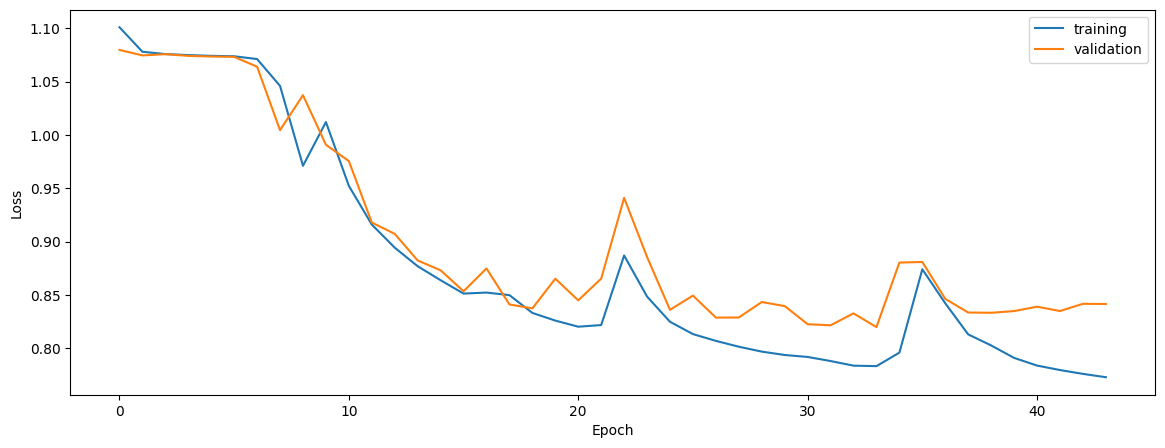

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6225527736085872


0.6234756600796255


0.6284211646593469


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.6786641610547283


0.6518252400735545


0.6757672884912491


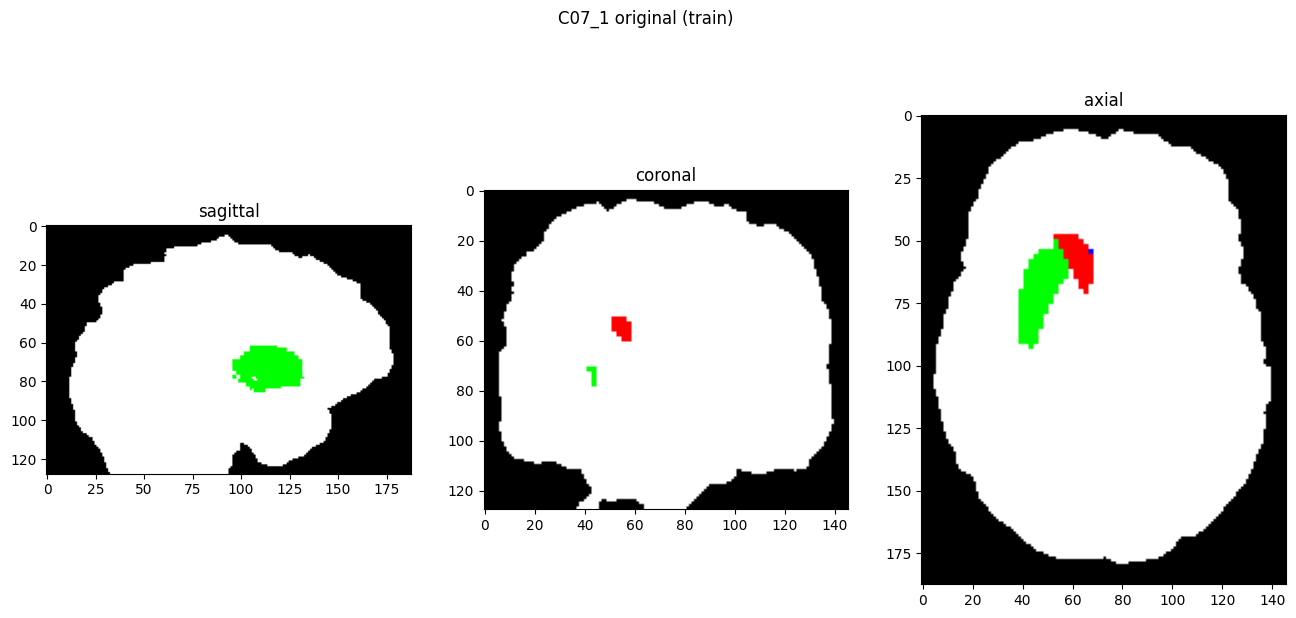

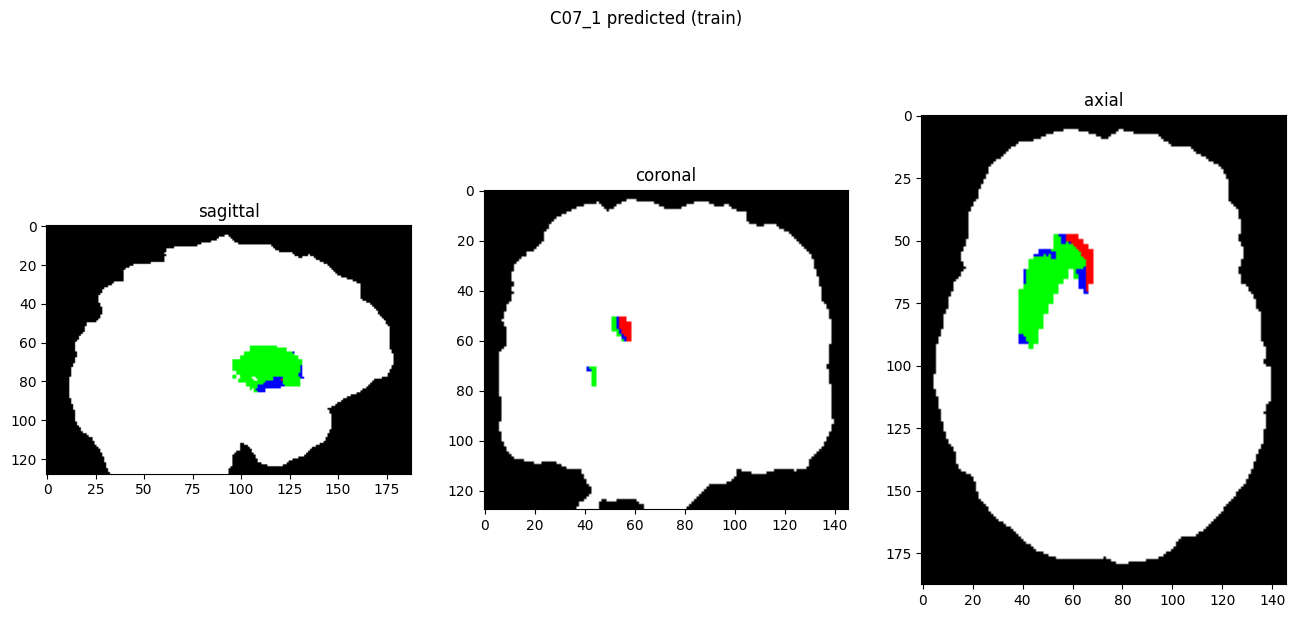

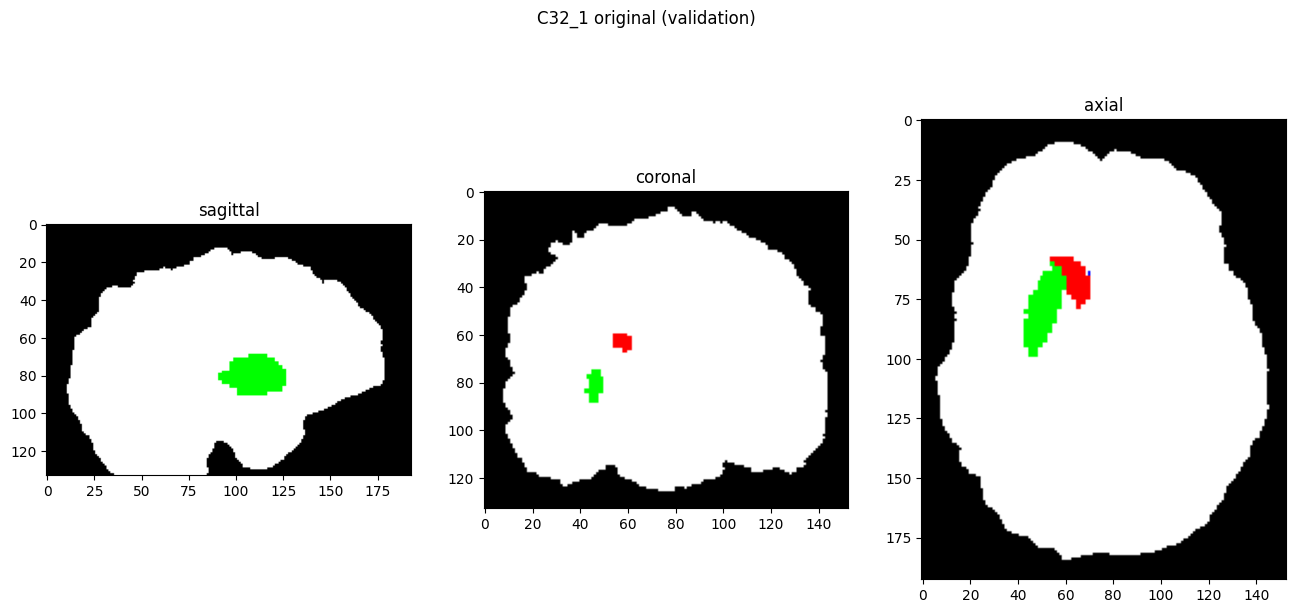

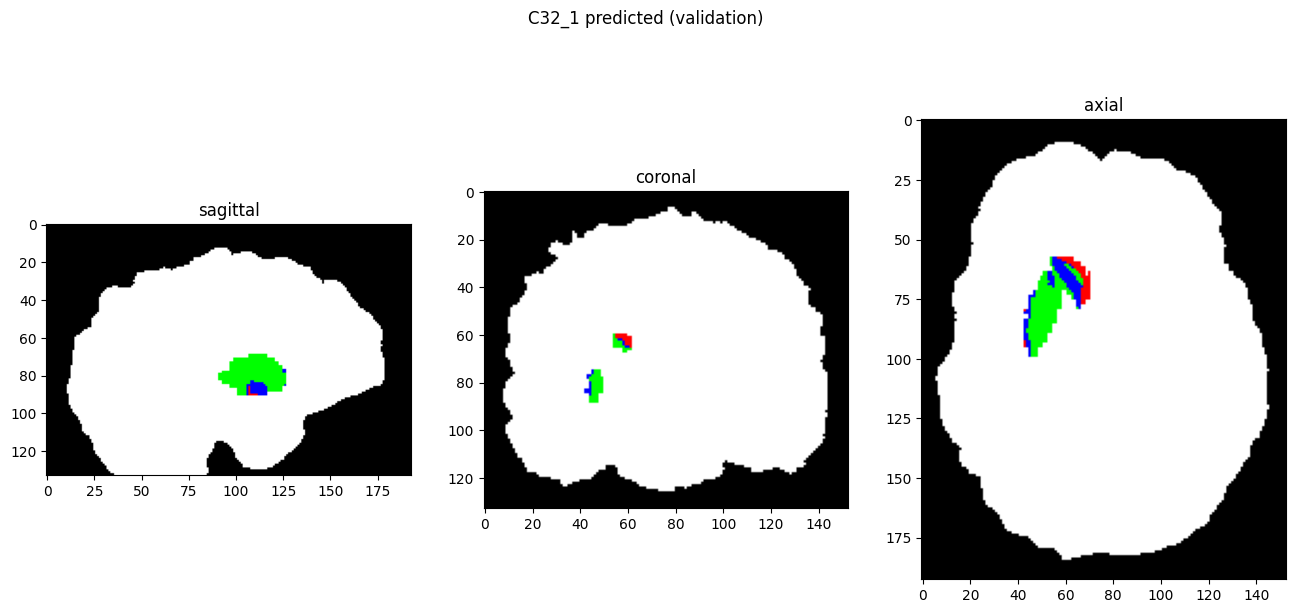

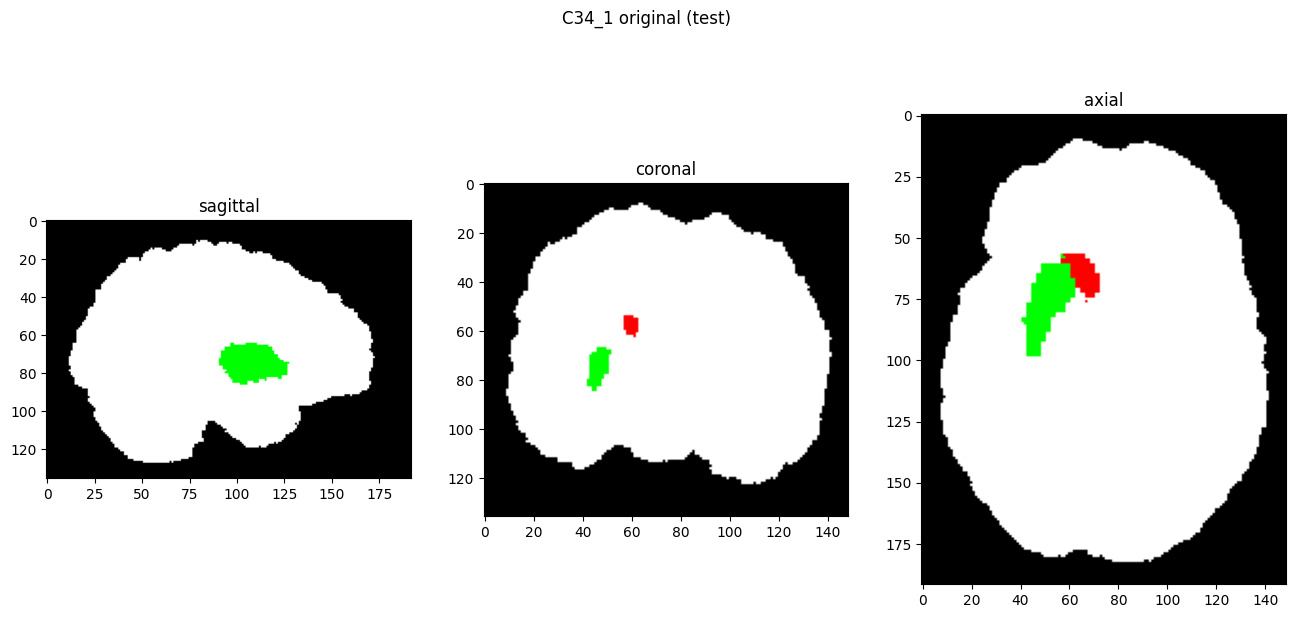

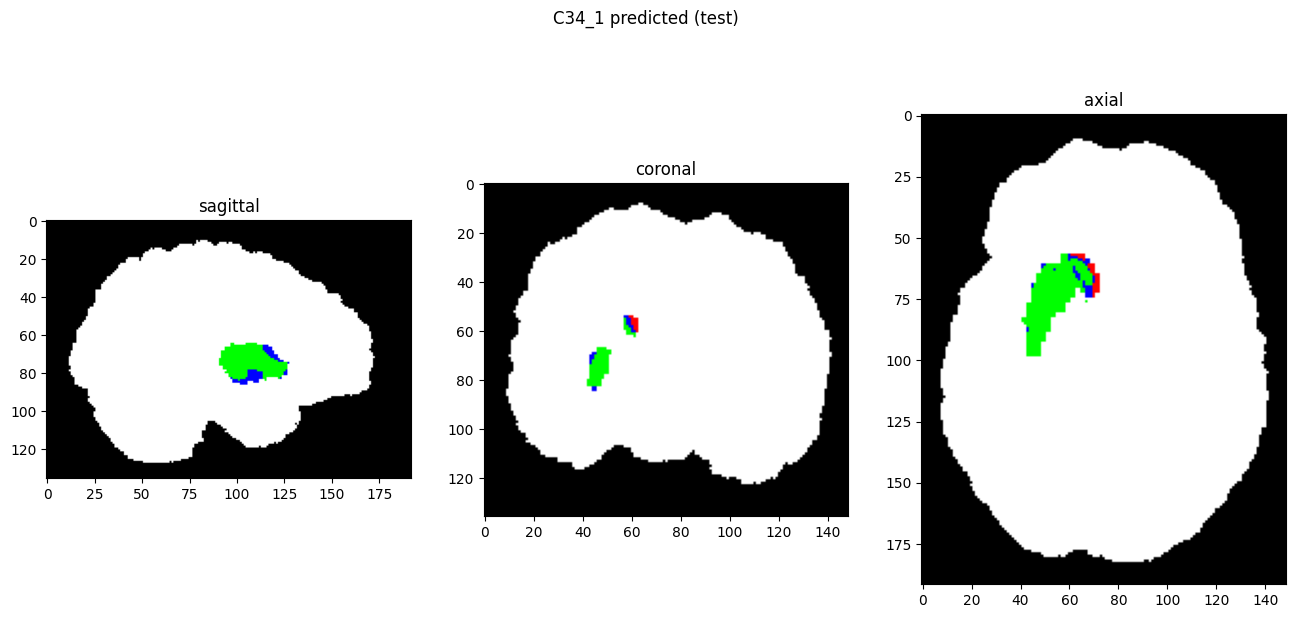

In [9]:
showResults(model, gen, threshold=0)